# **Thêm thư viện cần thiết**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, 
    LayerNormalization, Attention, GlobalMaxPooling1D, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Add
from tensorflow.keras.layers import Layer
from transformers import TFAutoModel
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import LearningRateScheduler

# **Class xử lý data sentiment comment trước khi đưa vào mô hình**

In [2]:
# Dataset Class
class SentimentCommentDataset:
    def __init__(self, file_path, tokenizer_name="vinai/phobert-large", max_length=128):
        self.file_path = file_path
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.load_data()

    def clean_data(self, data):
        data = data.dropna(subset=['comment'])
        data['comment'] = data['comment'].astype(str)
        data['label'] = data['label'].astype(int)
        return data

    def load_data(self):
        data = pd.read_csv(self.file_path)
        data = self.clean_data(data)
        self.comments = data['comment']
        self.labels = np.array(data['label'])

    def tokenize_data(self):
        inputs = self.tokenizer(
            list(self.comments),
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="np"
        )
        self.X = inputs['input_ids']
        self.X_attention = inputs['attention_mask']

    def split_data(self, test_size=0.15, val_size=0.15, random_state=42):
        train_val_size = 1 - test_size
        X_train_val, X_test, X_attention_train_val, X_attention_test, y_train_val, y_test = train_test_split(
            self.X, self.X_attention, self.labels, test_size=test_size, random_state=random_state
        )
        val_relative_size = val_size / train_val_size
        X_train, X_val, X_attention_train, X_attention_val, y_train, y_val = train_test_split(
            X_train_val, X_attention_train_val, y_train_val, test_size=val_relative_size, random_state=random_state
        )
        print("\nSố lượng mẫu Train:", len(X_train))
        print("Số lượng mẫu Val:", len(X_val))
        print("Số lượng mẫu Test:", len(X_test))

        self.X_train, self.X_val, self.X_test = X_train, X_val, X_test
        self.X_attention_train, self.X_attention_val, self.X_attention_test = X_attention_train, X_attention_val, X_attention_test
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test



**Xây dựng mô hình với kiến trúc CNN + BiLSTM**

In [3]:
class PhoBERTEmbeddingLayer(Layer):
    def __init__(self, pretrained_model_name="vinai/phobert-large", **kwargs):
        super(PhoBERTEmbeddingLayer, self).__init__(**kwargs)
        self.phobert = TFAutoModel.from_pretrained(pretrained_model_name)

    def call(self, inputs, **kwargs):
        input_ids, attention_mask = inputs
        output = self.phobert(input_ids=input_ids, attention_mask=attention_mask)[0]
        return output

    def get_config(self):
        config = super(PhoBERTEmbeddingLayer, self).get_config()
        return config

# Replace the Lambda layer with the custom PhoBERTEmbeddingLayer
class CNN_with_BiLSTM:
    def __init__(self, pretrained_model_name="vinai/phobert-large", max_length=128, lstm_units=512):
        self.max_length = max_length
        self.lstm_units = lstm_units
        self.hidden_size = 1024  # PhoBERT-large hidden size
        self.pretrained_model_name = pretrained_model_name
        self.build_model()

    def build_model(self):
        input_ids = Input(shape=(self.max_length,), dtype='int32', name='input_ids')
        attention_mask = Input(shape=(self.max_length,), dtype='int32', name='attention_mask')

        # PhoBERT Embedding
        embedding = PhoBERTEmbeddingLayer(pretrained_model_name=self.pretrained_model_name)([input_ids, attention_mask])

        # Enhanced CNN Layers
        cnn1 = Conv1D(512, kernel_size=3, activation='relu', padding='same')(embedding)
        cnn1 = Conv1D(512, kernel_size=3, activation='relu', padding='same')(cnn1)
        cnn1 = MaxPooling1D(pool_size=2)(cnn1)
        cnn1 = Dropout(0.3)(cnn1)

        cnn2 = Conv1D(1024, kernel_size=3, activation='relu', padding='same')(cnn1)
        cnn2 = Conv1D(1024, kernel_size=3, activation='relu', padding='same')(cnn2)
        cnn2 = MaxPooling1D(pool_size=2)(cnn2)
        cnn2 = Dropout(0.4)(cnn2)

        # Attention-based Fusion between PhoBERT embedding and CNN output
        attention_layer = MultiHeadAttention(num_heads=8, key_dim=embedding.shape[-1])(cnn2, embedding)
        fused_features = Add()([attention_layer, cnn2])  # Fusion with CNN
        fused_features = LayerNormalization()(fused_features)

        # Bidirectional LSTM for sequential modeling
        bilstm_layer = Bidirectional(LSTM(self.lstm_units, return_sequences=True, dropout=0.4))(fused_features)
        
        # Multi-Head Self-Attention for contextual understanding
        multi_head_attention = MultiHeadAttention(num_heads=8, key_dim=self.lstm_units)(bilstm_layer, bilstm_layer)
        
        # Residual Connection + Layer Normalization
        attention_output = Add()([multi_head_attention, bilstm_layer])
        attention_output = LayerNormalization()(attention_output)
        
        # Global Pooling for fixed-size representation
        pooled_output = GlobalMaxPooling1D()(attention_output)
        
        # Fully Connected Layers for non-linear transformation
        dense_layer_1 = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pooled_output)
        dense_layer_1 = Dropout(0.4)(dense_layer_1)
        
        dense_layer_2 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dense_layer_1)
        dense_layer_2 = Dropout(0.3)(dense_layer_2)
        
        # Output Layer
        output_layer = Dense(1, activation='sigmoid')(dense_layer_2)

        # Model Initialization
        self.model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

    def compile_model(self, learning_rate=1e-4):
        optimizer = Adam(learning_rate=learning_rate, decay=1e-6)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

**Hàm huấn luyện mô hình**

In [4]:
# Lịch trình Learning Rate với warm-up và giới hạn tối thiểu
class WarmUpCosineDecayScheduler(LearningRateScheduler):
    def __init__(self, learning_rate, warmup_steps, total_steps, min_lr=1e-6):
        def lr_schedule(epoch):
            if epoch < warmup_steps:
                lr = learning_rate * (epoch + 1) / warmup_steps
            else:
                lr = learning_rate * 0.5 * (1 + tf.math.cos((epoch - warmup_steps) / (total_steps - warmup_steps) * tf.constant(np.pi)))
            # Đảm bảo learning rate không giảm dưới min_lr
            return float(max(lr, min_lr))
        super().__init__(lr_schedule)


# Training and Evaluation Class
class Trainer:
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.history = None  # Để lưu lại lịch sử huấn luyện

    def train(self, epochs=30, batch_size=16, checkpoint_path='/kaggle/working/best_model.keras', callbacks=None):
        if callbacks is None:
            callbacks = []  # Nếu không truyền callback, dùng danh sách mặc định

        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=0)

        # Gộp callback mặc định và callback do người dùng cung cấp
        callbacks.extend([lr_scheduler, early_stopping, checkpoint])

        # Huấn luyện mô hình và lưu lại lịch sử
        self.history = self.model.fit(
            [self.dataset.X_train, self.dataset.X_attention_train],
            self.dataset.y_train,
            validation_data=([self.dataset.X_val, self.dataset.X_attention_val], self.dataset.y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )

    def evaluate(self):
        y_pred = (self.model.predict([self.dataset.X_test, self.dataset.X_attention_test]) > 0.5).astype('int32')
        print(classification_report(self.dataset.y_test, y_pred))
        self.plot_confusion_matrix(self.dataset.y_test, y_pred)

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    def save_model(self, save_path="/kaggle/working/sentiment_model.keras"):
        self.model.save(save_path, save_format='h5')  # Lưu mô hình với định dạng h5
        print(f"Mô hình đã được lưu tại: {save_path}")

    def plot_training_history(self):
        if not self.history:
            print("Chưa có lịch sử huấn luyện để vẽ biểu đồ.")
            return

        # Vẽ biểu đồ Loss
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Vẽ biểu đồ Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [5]:
pip install ipywidgets --upgrade


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 

# **Chạy chương trình huấn luyện mô hình, đánh giá kết quả trên tập test khi hoàn thành**

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Số lượng mẫu Train: 24126
Số lượng mẫu Val: 5171
Số lượng mẫu Test: 5171


tf_model.h5:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Cấu trúc của mô hình:



/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pho_bert_embedding… │ (None, 128, 1024) │          0 │ input_ids[0][0],  │
│ (PhoBERTEmbeddingL… │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 512)  │  1,573,376 │ pho_bert_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 512)  │    786,944 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 64, 512)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 512)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 64, 1024)  │  1,573,888 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 64, 1024)  │  3,146,752 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 32, 1024)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 1024)  │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 32, 1024)  │ 33,580,032 │ dropout_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ pho_bert_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 1024)  │          0 │ multi_head_atten… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 32, 1024)  │      2,048 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32, 1024)  │  6,295,552 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 32, 1024)  │ 16,790,528 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 1024)  │          0 │ multi_head_atten… │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 1024)  │      2,048 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ layer_normalizat

 Total params: 64,046,593 (244.32 MB)

 Trainable params: 64,046,593 (244.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 789s 503ms/step - accuracy: 0.6016 - loss: 6.3496 - val_accuracy: 0.8029 - val_loss: 5.7102 - learning_rate: 6.0000e-06
Epoch 2/30
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 752s 498ms/step - accuracy: 0.8102 - loss: 5.4116 - val_accuracy: 0.8550 - val_loss: 4.5622 - learning_rate: 1.2000e-05
Epoch 3/30
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 752s 499ms/step - accuracy: 0.8261 - loss: 4.2626 - val_accuracy: 0.8722 - val_loss: 3.2403 - learning_rate: 1.8000e-05
Epoch 4/30
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 753s 500ms/step - accuracy: 0.8509 - loss: 2.9268 - val_accuracy: 0.8853 - val_loss: 1.9991 - learning_rate: 2.4000e-05
Epoch 5/30
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 752s 499ms/step - accuracy: 0.8620 - loss: 1.7723 - val_accuracy: 0.8820 - val_loss: 1.1592 - learning_rate: 3.0000e-05
Epoch 6/30
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 752s 499ms/step - accuracy: 0.8825 - loss: 1.0304 - val_accuracy: 0.9016 - val_loss: 0.7077 - learning_rate: 3.0000e-05
Epoch 7/30
1508/1508 ━━━━━━━

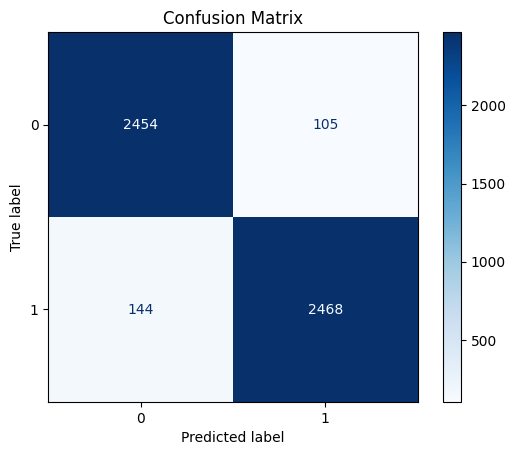

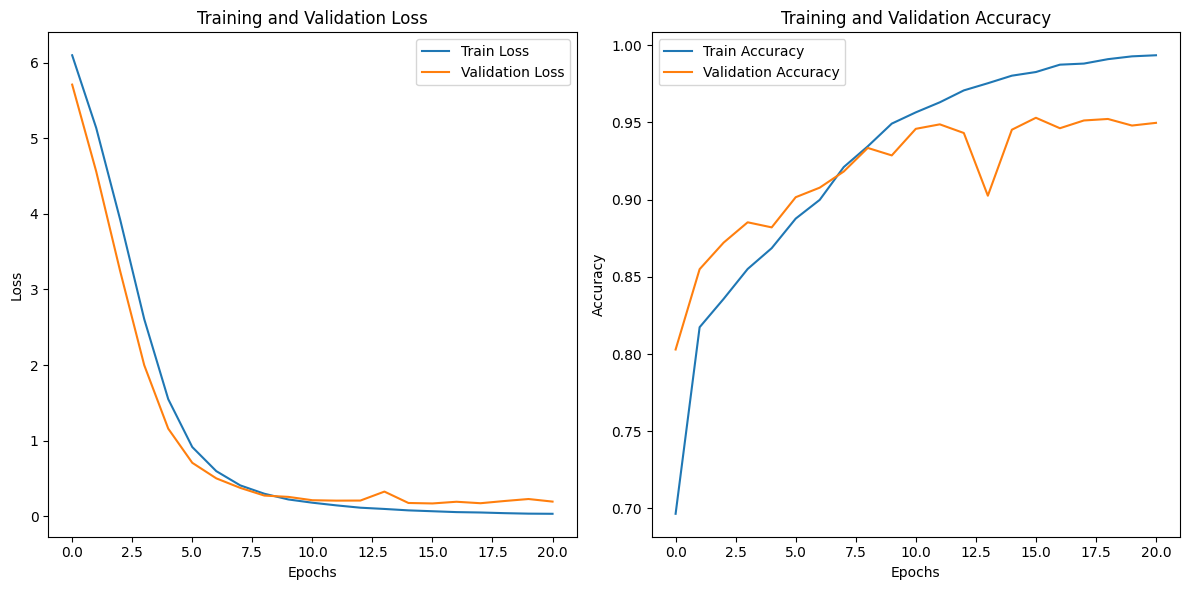

Mô hình đã được lưu tại: /kaggle/working/sentiment_model.keras


In [6]:
# --------------------------------Chạy chương trình--------------------------------
# Load dataset
dataset = SentimentCommentDataset(file_path="/kaggle/input/dataset-sentiment-v5/dataset_process_v5.csv", max_length=128)
dataset.tokenize_data()
dataset.split_data(test_size=0.15, val_size=0.15)

# Build and compile model
cnn_bilstm = CNN_with_BiLSTM(max_length=128)
cnn_bilstm.compile_model()

# In cấu trúc mô hình
print("\nCấu trúc của mô hình:\n")
cnn_bilstm.model.summary()


# Sử dụng Warm-Up Scheduler với ngưỡng tối thiểu
warmup_scheduler = WarmUpCosineDecayScheduler(
    learning_rate=3e-5, 
    warmup_steps=5, 
    total_steps=30, 
    min_lr=1e-7
)

# Train and evaluate
trainer = Trainer(cnn_bilstm.model, dataset)
trainer.train(
    epochs=30, 
    batch_size=16, 
    checkpoint_path='/kaggle/working/best_model.keras', 
    callbacks=[warmup_scheduler]
)
trainer.evaluate()

# Plot training history
trainer.plot_training_history()

# Save the model
trainer.save_model(save_path="/kaggle/working/sentiment_model.keras")

# **Test với các bình luận bất kỳ**

In [7]:
# from transformers import AutoTokenizer
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import load_model
# from transformers import TFAutoModel
# from tensorflow.keras.layers import Add
# from tensorflow.keras.layers import Layer

# # Tải tokenizer
# tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# # Định nghĩa lại PhoBERTEmbeddingLayer nếu cần
# class PhoBERTEmbeddingLayer(Layer):
#     def __init__(self, pretrained_model_name="vinai/phobert-base", **kwargs):
#         super(PhoBERTEmbeddingLayer, self).__init__(**kwargs)
#         self.phobert = TFAutoModel.from_pretrained(pretrained_model_name)

#     def call(self, inputs, **kwargs):
#         input_ids, attention_mask = inputs
#         output = self.phobert(input_ids=input_ids, attention_mask=attention_mask)[0]
#         return output

#     def get_config(self):
#         config = super(PhoBERTEmbeddingLayer, self).get_config()
#         return config

# # Tải mô hình từ tệp đã lưu
# model = load_model("/kaggle/working/sentiment_model.keras", custom_objects={'PhoBERTEmbeddingLayer': PhoBERTEmbeddingLayer, 'Add': Add})

# # Định nghĩa hàm tiền xử lý
# def preprocess_comment(comment, tokenizer, max_length=256):
#     inputs = tokenizer(
#         comment,
#         max_length=max_length,
#         padding="max_length",
#         truncation=True,
#         return_tensors="np"
#     )
#     input_ids = inputs["input_ids"]
#     attention_mask = inputs["attention_mask"]
#     return input_ids, attention_mask

# def predict_comment(comment, model, tokenizer, max_length=256):
#     input_ids, attention_mask = preprocess_comment(comment, tokenizer, max_length)
#     prediction = model.predict([input_ids, attention_mask])
#     label = int(prediction[0] > 0.5)  # Chuyển xác suất thành nhãn nhị phân
#     return label, prediction[0]


In [8]:
# import pandas as pd
# import re
# import os
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline

# # Load mô hình segmentation cho văn bản tiếng việt
# tokenizer_seg = AutoTokenizer.from_pretrained("NlpHUST/vi-word-segmentation")
# model_1 = AutoModelForTokenClassification.from_pretrained("NlpHUST/vi-word-segmentation")
# nlp = pipeline("token-classification", model=model_1, tokenizer=tokenizer_seg)

# #Các hàm tiền xử lý cho text phù hợp với dataset
# def word_weg(text, nlp):
#   ner_results = nlp(text)
#   example_tok = ""
#   for e in ner_results:
#       if "##" in e["word"]:
#           example_tok = example_tok + e["word"].replace("##","")
#       elif e["entity"] =="I":
#           example_tok = example_tok + "_" + e["word"]
#       elif ("." in e["word"]) or ("/" in e["word"]) or ("%" in e["word"]) or ("-" in e["word"]):
#         example_tok = example_tok + "" + e["word"]
#       else:
#         example_tok = example_tok + " " + e["word"]
#   return example_tok

# def split_sentence_into_chunks(sentence, max_length=512):
#     """Cắt câu dài thành các đoạn nhỏ hơn hoặc bằng max_length ký tự."""
#     chunks = []
#     while len(sentence) > max_length:
#         # Tìm vị trí dấu cách gần nhất trước giới hạn max_length
#         split_pos = sentence[:max_length].rfind(" ")
#         if split_pos == -1:  # Nếu không tìm thấy dấu cách
#             split_pos = max_length
#         chunks.append(sentence[:split_pos].strip())
#         sentence = sentence[split_pos:].strip()
#     if sentence:  # Thêm phần còn lại của câu
#         chunks.append(sentence)
#     return chunks

# def split_text_with_long_sentences(text, max_length=512):
#     """Cắt văn bản thành nhiều đoạn nhỏ hơn hoặc bằng max_length ký tự, bao gồm cả câu dài."""
#     text = text.strip()
#     sentences = re.split(r'(?<=[.])', text)  # Tách theo câu, giữ lại dấu chấm
#     chunks = []
#     for sentence in sentences:
#         sentence = sentence.strip()
#         if len(sentence) > max_length:
#             # Nếu câu vượt quá max_length, cắt thành các đoạn nhỏ
#             chunks.extend(split_sentence_into_chunks(sentence, max_length))
#         else:
#             # Nếu câu không vượt quá max_length, thêm vào danh sách
#             chunks.append(sentence)
#     return chunks

# # Hàm tiền xử lý cho text
# def preprocessing_text(text, nlp):
#     # lower text
#     text = text.lower()

#     # remove special char
#     allowed_special_chars = r"%"
#     allowed_chars = r"[^a-zA-Z0-9\s" + re.escape(allowed_special_chars) + r"àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđÀÁẠẢÃÂẦẤẬẨẪĂẰẮẶẲẴÈÉẸẺẼÊỀẾỆỂỄÌÍỊỈĨÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠÙÚỤỦŨƯỪỨỰỬỮỲÝỴỶỸĐ]"
#     text = re.sub(allowed_chars, '', text)

#     # word segmentor
#     text = word_weg(text, nlp)

#     # remove stop word
#     with open('/kaggle/input/dataset-sentiment-v1/vietnamese.txt', 'r', encoding='utf-8') as f:
#         stop_words = set(f.read().strip().split('\n'))
#     words = text.split()
#     filtered_words = [word for word in words if word not in stop_words]
#     text =' '.join(filtered_words)

#     return text

# def preprocessing_data(text, nlp):

#     sentences = split_text_with_long_sentences(text, max_length=512)

#     # Loại bỏ các câu rỗng hoặc chỉ chứa khoảng trắng
#     sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

#     # Nối kết quả sau xử lý bằng dấu cách
#     text = " ".join(preprocessing_text(sentence, nlp) for sentence in sentences)
#     return text

In [9]:
# # Ví dụ dự đoán
# example_comment = "Sản phẩm này hay đó"
# example_comment_pro=preprocessing_text(example_comment,nlp)
# print("Xử lý comment : ",example_comment_pro)
# label, prob = predict_comment(example_comment_pro, model, tokenizer)

# print(f"Nhận xét: \"{example_comment}\"")
# print(f"Dự đoán nhãn: {'Tích cực' if label == 0 else 'Tiêu cực'}")
# print(f"Xác suất dự đoán: {prob[0]:.4f}")